### Метрики відстані та візуалізація:

In [ ]:
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D



def distance(x1, x2, type = "euclidean"):
    if len(x1) == len(x2):
        if type == "euclidean":
            return (np.sum( (np.array(x1) - np.array(x2)) ** 2) ) ** (0.5)
        elif type == "euclidean_square":
            return (np.sum( (np.array(x1) - np.array(x2)) ** 2) )
        elif type == "L1":
            return np.sum( np.abs(np.array(x1) - np.array(x2)))
        elif type == "chebyshevan":
            return np.max( np.abs(np.array(x1) - np.array(x2)))
    return None


def vizualization3D(cluster, dop=[[0, 1, 2]]):
    for i in dop:
        fig = pyplot.figure()
        ax = Axes3D(fig)
        k = 0
        color = ['r', 'b', 'g', 'c', 'k', 'm']
        for dat in cluster:
            x = [j[i[0]] for j in dat]
            y = [j[i[1]] for j in dat]
            z = [j[i[2]] for j in dat]
            ax.scatter(x, y, z, c=color[k])
            k += 1
        pyplot.show()

### Функція нормалізації:

In [ ]:
def normalization(x):
    minx = min(x)
    maxx = max(x)
    temp = [(i - minx) / (maxx- minx) for i in x]
    return temp

### Підготовка даних:

In [ ]:
data = pd.read_excel('Диабет.xlsx')
data = data[["Вік", "Систолічний тиск", "Діастолічний тиск", "Вага"]]
data = data.dropna()
data = data.reset_index(drop=True)
age = normalization(data["Вік"])
sys = normalization(data["Систолічний тиск"])
dia = normalization(data["Діастолічний тиск"])
wei = normalization(data["Вага"])
# Можна зняти коментарій знизу для 4-хвимірного простору
# prepared_data = [[age[i], sys[i], dia[i], wei[i]] for i in range(len(age))]
prepared_data = [[age[i], sys[i], dia[i]] for i in range(len(age))]
prepared_data[:10]

[[0.3698630136986301, 0.175, 0.14473684210526316],
 [0.136986301369863, 0.1375, 0.2631578947368421],
 [0.5342465753424658, 0.625, 0.5789473684210527],
 [0.6575342465753424, 0.125, 0.02631578947368421],
 [0.6164383561643836, 0.3, 0.42105263157894735],
 [0.2054794520547945, 0.2625, 0.5],
 [0.1506849315068493, 0.44375, 0.8421052631578947],
 [0.3561643835616438, 0.4375, 0.42105263157894735],
 [0.4931506849315068, 0.1125, 0.3157894736842105],
 [0.5616438356164384, 0.25, 0.5526315789473685]]

Aлгоритм та застосувати його до даних з КП2. РОзділення кластерів проводити  по найдовшому ребру.


In [ ]:
def Krab(dataSet, k, type = "euclidean"):
    # Вибір випадкового центру
    centroid_index = random.randint(0, len(dataSet) - 1)
    centroid = dataSet[centroid_index]
    indexes = []
    indexes.append(centroid_index)
    temp = {}
    dists = []
    j = 0
    for i in dataSet:
        temp[str(j)] = dataSet[j]
        j += 1
    temp.pop(str(centroid_index))
    # прохід по всім точкам і вибір найкоротших відстаней:
    for j in range(len(dataSet) - 1):
        dis = {}
        for i in temp:
            dis[i] = distance(temp[i], centroid, type=type)
        minv = min(dis.keys(), key=(lambda k: dis[k]))
        indexes.append(int(minv))
        dists.append(dis[minv])
        centroid = temp[minv]
        temp.pop(minv)

    dd = dists.copy()
    # Вибір найдовших ребер
    long = []
    for j in range(k - 1):
        t = max(dd)
        long.append(dists.index(t))
        dd.remove(t)

    long.sort()
    prnt(indexes, dists, long)
    # Поділ на кластери
    for j in range(k):
        if j == 0:
            temp[str(j + 1)] = [i for i in indexes[:long[j] + 1]]
        elif j == k - 1:
            temp[str(j + 1)] = [i for i in indexes[long[j - 1] + 1:]]
        else:
            temp[str(j + 1)] = [i for i in indexes[long[j - 1] + 1: long[j] + 1]]
    data = []
    for j in range(k):
        data.append([dataSet[i] for i in range(len(dataSet)) if i in temp[str(j + 1)]])

    return data

# Функція для виводу кроків та коефіцієнтів
def prnt(ind, dis, long):
    graph = pd.DataFrame({"Об'єкт 1" : [ind[i] for i in range(len(dis))],
                          "Об'єкт 2" : [ind[i + 1] for i in range(len(dis))],
                          "Відстань" : [dis[i] for i in range(len(dis))]})
    print(graph)
    print("--------------------")
    print("Найдовші ребра: ")
    for i in long:
        print(graph.loc[i])
        print("--------------------")
    print("Міри близькості класів:")
    p = 0
    f = 0
    for i in range(len(long)):
        if f - long[i] == 0:
            p1 = 0
        else:
            p1 = np.mean(dis[f:long[i]])
        f = long[i] + 1
        p += p1
        print("p" + str(i) + " = ", p1)
    if long[-1] == len(dis) - 1:
        p1 = 0
    else:
        p1 = np.mean(dis[long[-1] + 1:])
    p += p1
    print("p" + str(len(long) + 1) + " = ", p1)
    P = p / (len(long) + 1)
    print("    Загальна міра близькості\n\tp = ", P)
    p1 = 0
    for i in range(len(long)):
        p1 += dis[long[i]]
    D = p1 / len(long)
    print("    Загальна відстань між класами\n\td = ", D)

    p1 = 0
    for i in range(len(long)):
        if long[i] == 0:
            a = dis[long[i] + 1]
        elif long[i] == len(dis) - 1:
            a = dis[long[i] - 1]
        else:
            a = min(dis[long[i] - 1], dis[long[i] + 1])
        p1 += a / dis[long[i]]
    L = p1 / len(long)
    print("    Загальна міра неоднорідності\n\tλ = ", L)

    p1 = (len(long) + 1)**(len(long) + 1)
    j = 0
    for i in range(len(long)):
        p1 *= (long[i] - j) / len(ind)
        j = long[i]
    p1 *= (len(ind) - j) / len(ind)
    H = p1
    print("    Рівномірність розподілу точок\n\th = ", p1 / len(long))
    print("    Загальний критерій якості\n\tF = ", np.log((D*H)/(L*P)))

2. Вивести таблицю з кроками об'єднання. 
3. Оцінити якість кластеризації за критерієм F. Вивести значення всіх чотирьох характеристик.

In [ ]:
print("Кроки об'єднання:")
cluster2 = Krab(prepared_data, 2)
a = 1
for i in cluster2:
      print("Claster №" + str(a) + "\nCount " + str(len(i)))
      a += 1
      print(i[:5])

Кроки об'єднання:
     Об'єкт 1  Об'єкт 2  Відстань
0         196       326  0.039992
1         326       255  0.069746
2         255       281  0.063870
3         281       201  0.019996
4         201       273  0.031029
..        ...       ...       ...
391       138       310  0.037500
392       310        35  0.151182
393        35        85  0.052278
394        85       386  0.351987
395       386        64  0.340176

[396 rows x 3 columns]
--------------------
Найдовші ребра: 
Об'єкт 1    286.000000
Об'єкт 2     23.000000
Відстань      0.431287
Name: 382, dtype: float64
--------------------
Міри близькості класів:
p0 =  0.06906134116581027
p2 =  0.1578146978560032
    Загальна міра близькості
	p =  0.11343801951090673
    Загальна відстань між класами
	d =  0.43128741283090094
    Загальна міра неоднорідності
	λ =  0.05796598568899579
    Рівномірність розподілу точок
	h =  0.14542316745871114
    Загальний критерій якості
	F =  2.255309618373178
Claster №1
Count 383
[[0.36986301

Візуалізація результатів 2-х кластерів

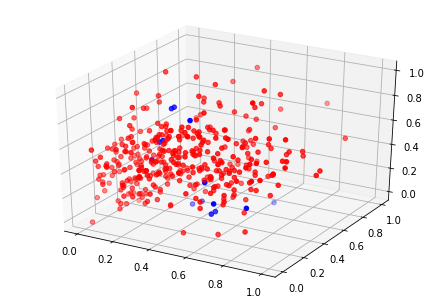

In [ ]:
vizualization3D(cluster2, [[0, 1, 2]])

Поділ на 3 кластери:

In [ ]:
print("Кроки об'єднання:")
cluster3 = Krab(prepared_data, 3)
a = 1
for i in cluster3:
      print("Claster №" + str(a) + "\nCount " + str(len(i)))
      a += 1
      print(i[:5])

Кроки об'єднання:
     Об'єкт 1  Об'єкт 2  Відстань
0          97        66  0.032194
1          66        24  0.044925
2          24       182  0.028251
3         182       264  0.039924
4         264       377  0.029668
..        ...       ...       ...
391       285       209  0.253713
392       209        86  0.243321
393        86        79  0.380964
394        79       332  0.303615
395       332       256  0.724971

[396 rows x 3 columns]
--------------------
Найдовші ребра: 
Об'єкт 1    391.000000
Об'єкт 2     64.000000
Відстань      0.564745
Name: 358, dtype: float64
--------------------
Об'єкт 1    332.000000
Об'єкт 2    256.000000
Відстань      0.724971
Name: 395, dtype: float64
--------------------
Міри близькості класів:
p0 =  0.06802001080373697
p1 =  0.10963201060161863
p3 =  0
    Загальна міра близькості
	p =  0.05921734046845187
    Загальна відстань між класами
	d =  0.6448576774060791
    Загальна міра неоднорідності
	λ =  0.48871997490200414
    Рівномірність розпо

Візуалізація 3-х кластерів

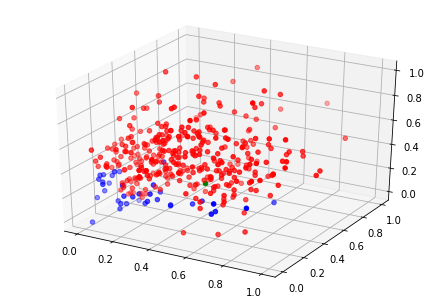

In [ ]:
vizualization3D(cluster3, [[0, 1, 2]])